In [48]:
import pandas as pd
import numpy as np
import pytorch_tabnet
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import accuracy_score, classification_report
from pytorch_tabnet.metrics import Metric
from sklearn.metrics import roc_auc_score
from sklearn import model_selection, metrics
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt


In [49]:
train = pd.read_csv('../data/6_train_dataset_augmented.csv')
train.head()

,is_fraud,ERC20_num_unique_senders_to_acc,total_transactions,ERC20_num_unique_senders_contract_to_acc,total_value_sent_ratio,avg_value_sent,num_received_to_total_txns_ratio,min_value_sent,ERC20_num_unique_recipients_from_acc,num_unique_senders_to_acc,...,num_unique_recipients_from_acc,first_and_last_txns_time_diff,total_value_received_ratio,has_sent_ERC20,max_value_sent,avg_time_between_received_txns,min_value_received,avg_time_between_sent_txns,total_ERC20_sent_contract_in_ether,ERC20_max_value_sent
0,0,0.0,111,0.0,0.500672,0.156104,0.504505,0.015341,0.0,3,...,2,450875.98,0.499328,0,1.001666,8048.14,0.015761,3.28,0.0,0.0
1,0,0.0,260,0.0,0.500388,0.270446,0.500000,0.025580,0.0,2,...,2,136967.03,0.499612,0,0.791452,957.18,0.026000,96.42,0.0,0.0
2,0,0.0,6,0.0,0.500005,25.249470,0.333333,0.004454,0.0,2,...,2,331.23,0.499995,0,100.414520,0.02,26.376409,82.80,0.0,0.0
3,1,0.0,7,0.0,0.000000,0.000000,0.857143,0.000000,0.0,3,...,0,176158.57,0.000000,0,0.000000,29359.76,0.000000,0.00,0.0,0.0
4,1,0.0,6,0.0,0.000000,0.000000,0.833333,0.000000,0.0,3,...,0,173765.32,0.000000,0,0.000000,34753.06,0.000000,0.00,0.0,0.0


In [50]:
test = pd.read_csv('../data/4_test_dataset.csv')
test.head()

,is_fraud,ERC20_num_unique_senders_to_acc,total_transactions,ERC20_num_unique_senders_contract_to_acc,total_value_sent_ratio,avg_value_sent,num_received_to_total_txns_ratio,min_value_sent,ERC20_num_unique_recipients_from_acc,num_unique_senders_to_acc,...,num_unique_recipients_from_acc,first_and_last_txns_time_diff,total_value_received_ratio,has_sent_ERC20,max_value_sent,avg_time_between_received_txns,min_value_received,avg_time_between_sent_txns,total_ERC20_sent_contract_in_ether,ERC20_max_value_sent
0,1,0.0,2,0.0,0.503905,0.098450,0.500000,0.098450,0.0,1,...,1,1648.68,0.496095,0,0.098450,0.00,0.100000,0.00,0.0,0.00000
1,0,2.0,146,2.0,1.000000,0.000000,0.993151,0.000000,0.0,3,...,0,229000.73,0.000000,0,0.000000,1579.32,0.000000,0.00,0.0,0.00000
2,0,0.0,24,0.0,0.501887,0.076196,0.500000,0.048476,0.0,2,...,12,99075.63,0.498113,0,0.156897,8170.50,0.049115,85.81,0.0,0.00000
3,0,29.0,109,43.0,0.494445,3.148239,0.321101,0.000000,2.0,5,...,41,728358.93,0.505555,1,20.200000,2453.79,0.152000,8682.11,0.0,20173.81535
4,0,5.0,1,5.0,1.000000,0.000000,1.000000,0.000000,0.0,1,...,0,0.00,0.000000,0,0.000000,0.00,0.681968,0.00,0.0,0.00000


In [51]:
X_train = train.drop(['is_fraud'],axis=1)
y_train = train['is_fraud']

X_test = test.drop(['is_fraud'],axis=1)
y_test = test['is_fraud']


print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(59164, 21) (59164,)
(3927, 21) (3927,)


In [52]:
X_train_np, X_test_np, y_train_np, y_test_np = (
    X_train.to_numpy(),
    X_test.to_numpy(),
    y_train.to_numpy(),
    y_test.to_numpy(),
)

In [53]:

class Recall(Metric):
    def __init__(self):
        self._name = "recall"
        self._maximize = True

    def __call__(self, y_true, y_pred):
        recall = recall_score(y_true, y_pred)
        return recall


In [54]:
tn_clf = TabNetClassifier()


Device used : cpu


In [12]:
tn_clf.fit(
    X_train_np, y_train_np,
    eval_metric=[Recall]
)


No early stopping will be performed, last training weights will be used.


epoch 0  | loss: 0.59006 |  0:00:03s
epoch 1  | loss: 0.52589 |  0:00:07s
epoch 2  | loss: 0.50319 |  0:00:10s
epoch 3  | loss: 0.49233 |  0:00:13s
epoch 4  | loss: 0.47634 |  0:00:17s
epoch 5  | loss: 0.47066 |  0:00:20s
epoch 6  | loss: 0.46615 |  0:00:23s
epoch 7  | loss: 0.46112 |  0:00:27s
epoch 8  | loss: 0.4563  |  0:00:31s
epoch 9  | loss: 0.45163 |  0:00:35s
epoch 10 | loss: 0.45455 |  0:00:38s
epoch 11 | loss: 0.45363 |  0:00:41s
epoch 12 | loss: 0.44806 |  0:00:44s
epoch 13 | loss: 0.44556 |  0:00:47s
epoch 14 | loss: 0.44916 |  0:00:50s
epoch 15 | loss: 0.44181 |  0:00:53s
epoch 16 | loss: 0.44303 |  0:00:56s
epoch 17 | loss: 0.4454  |  0:00:59s
epoch 18 | loss: 0.44769 |  0:01:02s
epoch 19 | loss: 0.43928 |  0:01:05s
epoch 20 | loss: 0.43635 |  0:01:08s
epoch 21 | loss: 0.43152 |  0:01:11s
epoch 22 | loss: 0.43987 |  0:01:14s
epoch 23 | loss: 0.43685 |  0:01:17s
epoch 24 | loss: 0.43149 |  0:01:19s
epoch 25 | loss: 0.42725 |  0:01:23s
epoch 26 | loss: 0.42812 |  0:01:26s
e

In [13]:
y_pred = tn_clf.predict(X_train_np)
print('recall:', metrics.recall_score(y_train_np, y_pred))

recall: 0.7676965722398756


In [14]:
y_pred = tn_clf.predict(X_test_np)
print('recall:', metrics.recall_score(y_test_np, y_pred))

recall: 0.9139908256880734


In [15]:
y_pred = tn_clf.predict(X_test_np)
print('accuracy:', metrics.accuracy_score(y_test_np, y_pred))


accuracy: 0.7641965877259995


In [55]:
tn_clf.get_params

<bound method BaseEstimator.get_params of TabNetClassifier(n_d=8, n_a=8, n_steps=3, gamma=1.3, cat_idxs=[], cat_dims=[], cat_emb_dim=[], n_independent=2, n_shared=2, epsilon=1e-15, momentum=0.02, lambda_sparse=0.001, seed=0, clip_value=1, verbose=1, optimizer_fn=<class 'torch.optim.adam.Adam'>, optimizer_params={'lr': 0.02}, scheduler_fn=None, scheduler_params={}, mask_type='sparsemax', input_dim=None, output_dim=None, device_name='auto', n_shared_decoder=1, n_indep_decoder=1, grouped_features=[])>

In [56]:
#Hyperparameter tuning
param_grid = {
    'n_d': [8, 12],               
    'n_a': [8, 12],                
    'n_steps': [3, 5],             
    #'gamma': [1,1.3,1.5],     
    #'n_independent': [1, 2],        
    #'n_shared': [1, 2],             
    'momentum':[0.02,0.4],
    #'device_name' : ['gpu']
}

In [57]:
tn_clf_tuning = TabNetClassifier()

Device used : cpu


In [58]:
tn1 = model_selection.RandomizedSearchCV(tn_clf_tuning, param_distributions= param_grid,cv=3,scoring= "recall", n_jobs=-1)


In [59]:
best_tn_recall = tn1.fit(
    X_train_np, y_train_np,
    eval_metric=[Recall],
    patience = 10,
    batch_size = 1024,
    virtual_batch_size = 128,
    
)


/Users/jackho/Desktop/BT4012/final proj/BT4012-Project/.venv/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/Users/jackho/Desktop/BT4012/final proj/BT4012-Project/.venv/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/Users/jackho/Desktop/BT4012/final proj/BT4012-Project/.venv/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/Users/jackho/Desktop/BT4012/final proj/BT4012-Project/.venv/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/Users/jackho/Desktop/BT4012/final proj/BT40

epoch 0  | loss: 0.60214 |  0:00:03s
epoch 0  | loss: 0.59914 |  0:00:03s
epoch 0  | loss: 0.52691 |  0:00:04s
epoch 0  | loss: 0.6311  |  0:00:04s
epoch 0  | loss: 0.62398 |  0:00:04s
epoch 0  | loss: 0.65023 |  0:00:06s
epoch 0  | loss: 0.64268 |  0:00:06s
epoch 0  | loss: 0.60359 |  0:00:06s
epoch 1  | loss: 0.51594 |  0:00:08s
epoch 1  | loss: 0.52095 |  0:00:08s
epoch 1  | loss: 0.50423 |  0:00:09s
epoch 1  | loss: 0.4185  |  0:00:09s
epoch 1  | loss: 0.51099 |  0:00:09s
epoch 1  | loss: 0.55917 |  0:00:12s
epoch 1  | loss: 0.54041 |  0:00:12s
epoch 1  | loss: 0.46572 |  0:00:12s
epoch 2  | loss: 0.48865 |  0:00:12s
epoch 2  | loss: 0.49014 |  0:00:12s
epoch 2  | loss: 0.48845 |  0:00:13s
epoch 2  | loss: 0.39496 |  0:00:13s
epoch 2  | loss: 0.48896 |  0:00:13s
epoch 3  | loss: 0.47665 |  0:00:16s
epoch 3  | loss: 0.47701 |  0:00:16s
epoch 3  | loss: 0.47335 |  0:00:17s
epoch 3  | loss: 0.39128 |  0:00:17s
epoch 3  | loss: 0.47371 |  0:00:17s
epoch 2  | loss: 0.54732 |  0:00:17s
e

/Users/jackho/Desktop/BT4012/final proj/BT4012-Project/.venv/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 68 | loss: 0.40911 |  0:07:58s
epoch 68 | loss: 0.42372 |  0:07:59s
epoch 68 | loss: 0.31735 |  0:07:59s
epoch 93 | loss: 0.38859 |  0:08:02s


/Users/jackho/Desktop/BT4012/final proj/BT4012-Project/.venv/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 93 | loss: 0.36969 |  0:08:04s
epoch 0  | loss: 0.4896  |  0:00:05s
epoch 93 | loss: 0.29182 |  0:08:04s
epoch 69 | loss: 0.41165 |  0:08:09s
epoch 69 | loss: 0.42118 |  0:08:09s
epoch 69 | loss: 0.31815 |  0:08:12s
epoch 0  | loss: 0.59914 |  0:00:12s
epoch 94 | loss: 0.3857  |  0:08:14s
epoch 1  | loss: 0.40691 |  0:00:16s
epoch 94 | loss: 0.37093 |  0:08:16s
epoch 94 | loss: 0.28939 |  0:08:16s
epoch 1  | loss: 0.52095 |  0:00:17s
epoch 70 | loss: 0.41094 |  0:08:20s
epoch 95 | loss: 0.3789  |  0:08:20s
epoch 2  | loss: 0.39538 |  0:00:22s
epoch 70 | loss: 0.42058 |  0:08:21s
epoch 70 | loss: 0.31632 |  0:08:21s
epoch 95 | loss: 0.37238 |  0:08:21s
epoch 95 | loss: 0.29159 |  0:08:22s
epoch 2  | loss: 0.49014 |  0:00:22s
epoch 3  | loss: 0.38445 |  0:00:27s
epoch 96 | loss: 0.37895 |  0:08:25s
epoch 96 | loss: 0.36956 |  0:08:26s
epoch 96 | loss: 0.29023 |  0:08:26s
epoch 71 | loss: 0.40931 |  0:08:27s
epoch 71 | loss: 0.42234 |  0:08:27s
epoch 71 | loss: 0.31808 |  0:08:28s
e

/Users/jackho/Desktop/BT4012/final proj/BT4012-Project/.venv/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/Users/jackho/Desktop/BT4012/final proj/BT4012-Project/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jackho/Desktop/BT4012/final proj/BT4012-Project/.venv/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 74 | loss: 0.408   |  0:08:48s


/Users/jackho/Desktop/BT4012/final proj/BT4012-Project/.venv/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 74 | loss: 0.42464 |  0:08:48s
epoch 7  | loss: 0.45043 |  0:00:46s
epoch 8  | loss: 0.34599 |  0:00:50s
epoch 74 | loss: 0.31043 |  0:08:49s
epoch 0  | loss: 0.60214 |  0:00:04s
epoch 0  | loss: 0.4896  |  0:00:04s
epoch 8  | loss: 0.44547 |  0:00:50s
epoch 9  | loss: 0.34583 |  0:00:54s
epoch 0  | loss: 0.57894 |  0:00:04s
epoch 75 | loss: 0.40965 |  0:08:56s
epoch 1  | loss: 0.51594 |  0:00:11s
epoch 75 | loss: 0.42075 |  0:08:58s
epoch 75 | loss: 0.30996 |  0:08:59s
epoch 1  | loss: 0.40691 |  0:00:12s
epoch 10 | loss: 0.34366 |  0:01:03s
epoch 9  | loss: 0.44563 |  0:00:59s
epoch 1  | loss: 0.49833 |  0:00:13s
epoch 2  | loss: 0.48865 |  0:00:17s
epoch 2  | loss: 0.39538 |  0:00:18s
epoch 76 | loss: 0.40625 |  0:09:06s
epoch 10 | loss: 0.44054 |  0:01:04s
epoch 76 | loss: 0.42006 |  0:09:07s
epoch 76 | loss: 0.30837 |  0:09:08s
epoch 11 | loss: 0.3398  |  0:01:10s
epoch 2  | loss: 0.48087 |  0:00:20s
epoch 3  | loss: 0.47665 |  0:00:25s
epoch 3  | loss: 0.38445 |  0:00:25s
e

/Users/jackho/Desktop/BT4012/final proj/BT4012-Project/.venv/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 45 | loss: 0.39928 |  0:04:01s


/Users/jackho/Desktop/BT4012/final proj/BT4012-Project/.venv/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/Users/jackho/Desktop/BT4012/final proj/BT4012-Project/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jackho/Desktop/BT4012/final proj/BT4012-Project/.venv/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 38 | loss: 0.41521 |  0:03:19s
epoch 47 | loss: 0.30285 |  0:04:08s
epoch 35 | loss: 0.397   |  0:03:18s
epoch 38 | loss: 0.30774 |  0:03:19s
epoch 0  | loss: 0.58795 |  0:00:04s
epoch 46 | loss: 0.40067 |  0:04:05s
epoch 0  | loss: 0.47772 |  0:00:04s
epoch 39 | loss: 0.40899 |  0:03:24s
epoch 48 | loss: 0.30429 |  0:04:13s
epoch 36 | loss: 0.39543 |  0:03:23s
epoch 39 | loss: 0.30712 |  0:03:24s
epoch 0  | loss: 0.59895 |  0:00:07s
epoch 47 | loss: 0.39863 |  0:04:10s
epoch 1  | loss: 0.50727 |  0:00:09s
epoch 1  | loss: 0.40145 |  0:00:09s
epoch 40 | loss: 0.40534 |  0:03:29s
epoch 49 | loss: 0.301   |  0:04:18s
epoch 40 | loss: 0.30896 |  0:03:29s
epoch 37 | loss: 0.39357 |  0:03:29s
epoch 48 | loss: 0.39719 |  0:04:16s
epoch 2  | loss: 0.48467 |  0:00:15s
epoch 2  | loss: 0.37965 |  0:00:15s
epoch 41 | loss: 0.40102 |  0:03:33s
epoch 1  | loss: 0.51783 |  0:00:15s
epoch 50 | loss: 0.30165 |  0:04:22s
epoch 41 | loss: 0.31194 |  0:03:33s
epoch 38 | loss: 0.39355 |  0:03:33s
e

/Users/jackho/Desktop/BT4012/final proj/BT4012-Project/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jackho/Desktop/BT4012/final proj/BT4012-Project/.venv/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 91 | loss: 0.3923  |  0:07:01s
epoch 84 | loss: 0.37676 |  0:07:01s
epoch 91 | loss: 0.29582 |  0:07:02s
epoch 49 | loss: 0.39149 |  0:03:46s
epoch 31 | loss: 0.42239 |  0:03:45s
epoch 49 | loss: 0.31509 |  0:03:47s
epoch 99 | loss: 0.38619 |  0:07:49s
epoch 92 | loss: 0.3883  |  0:07:05s
epoch 92 | loss: 0.29697 |  0:07:05s
epoch 85 | loss: 0.37762 |  0:07:05s
epoch 50 | loss: 0.39441 |  0:03:50s
epoch 0  | loss: 0.62681 |  0:00:06s


/Users/jackho/Desktop/BT4012/final proj/BT4012-Project/.venv/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 50 | loss: 0.31501 |  0:03:51s
epoch 93 | loss: 0.38521 |  0:07:09s
epoch 32 | loss: 0.42076 |  0:03:52s
epoch 93 | loss: 0.29312 |  0:07:10s
epoch 86 | loss: 0.37692 |  0:07:10s
epoch 51 | loss: 0.3909  |  0:03:55s
epoch 51 | loss: 0.31102 |  0:03:55s
epoch 94 | loss: 0.38682 |  0:07:13s
epoch 1  | loss: 0.54171 |  0:00:13s
epoch 94 | loss: 0.29709 |  0:07:14s
epoch 0  | loss: 0.52538 |  0:00:07s
epoch 87 | loss: 0.37694 |  0:07:14s
epoch 52 | loss: 0.39448 |  0:03:59s
epoch 95 | loss: 0.38537 |  0:07:17s
epoch 52 | loss: 0.31087 |  0:04:00s
epoch 33 | loss: 0.41695 |  0:03:59s
epoch 95 | loss: 0.29644 |  0:07:17s
epoch 88 | loss: 0.37571 |  0:07:18s
epoch 53 | loss: 0.39329 |  0:04:03s
epoch 96 | loss: 0.38453 |  0:07:21s
epoch 2  | loss: 0.50515 |  0:00:20s
epoch 53 | loss: 0.30748 |  0:04:04s
epoch 1  | loss: 0.44681 |  0:00:13s
epoch 96 | loss: 0.29416 |  0:07:21s
epoch 34 | loss: 0.42107 |  0:04:05s
epoch 89 | loss: 0.37423 |  0:07:22s
epoch 54 | loss: 0.39132 |  0:04:07s
e

/Users/jackho/Desktop/BT4012/final proj/BT4012-Project/.venv/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 36 | loss: 0.42865 |  0:04:18s
epoch 57 | loss: 0.38444 |  0:04:20s


/Users/jackho/Desktop/BT4012/final proj/BT4012-Project/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jackho/Desktop/BT4012/final proj/BT4012-Project/.venv/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 57 | loss: 0.29859 |  0:04:21s
epoch 93 | loss: 0.375   |  0:07:39s
epoch 5  | loss: 0.47067 |  0:00:40s
epoch 58 | loss: 0.38361 |  0:04:25s
epoch 4  | loss: 0.41119 |  0:00:34s
epoch 58 | loss: 0.29898 |  0:04:25s
epoch 0  | loss: 0.588   |  0:00:06s
epoch 37 | loss: 0.43154 |  0:04:25s
epoch 0  | loss: 0.61095 |  0:00:06s
epoch 94 | loss: 0.37289 |  0:07:44s
epoch 59 | loss: 0.38325 |  0:04:29s
epoch 59 | loss: 0.29876 |  0:04:30s
epoch 6  | loss: 0.4646  |  0:00:47s
epoch 5  | loss: 0.39305 |  0:00:40s
epoch 95 | loss: 0.375   |  0:07:48s
epoch 1  | loss: 0.50941 |  0:00:13s
epoch 60 | loss: 0.38624 |  0:04:34s
epoch 38 | loss: 0.42767 |  0:04:32s
epoch 1  | loss: 0.5401  |  0:00:13s
epoch 60 | loss: 0.29822 |  0:04:34s
epoch 96 | loss: 0.37238 |  0:07:53s
epoch 7  | loss: 0.45525 |  0:00:54s
epoch 61 | loss: 0.38378 |  0:04:38s
epoch 61 | loss: 0.29585 |  0:04:39s
epoch 2  | loss: 0.4902  |  0:00:19s
epoch 6  | loss: 0.38696 |  0:00:48s
epoch 39 | loss: 0.42153 |  0:04:40s
e

/Users/jackho/Desktop/BT4012/final proj/BT4012-Project/.venv/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 65 | loss: 0.38553 |  0:04:57s
epoch 65 | loss: 0.29237 |  0:04:58s
epoch 5  | loss: 0.46231 |  0:00:40s
epoch 10 | loss: 0.4421  |  0:01:16s
epoch 66 | loss: 0.38767 |  0:05:01s
epoch 9  | loss: 0.37708 |  0:01:10s
epoch 5  | loss: 0.522   |  0:00:40s
epoch 42 | loss: 0.41443 |  0:05:01s
epoch 66 | loss: 0.29144 |  0:05:02s
epoch 0  | loss: 0.51309 |  0:00:06s
epoch 67 | loss: 0.38667 |  0:05:06s
epoch 6  | loss: 0.45712 |  0:00:47s
epoch 67 | loss: 0.29334 |  0:05:06s
epoch 11 | loss: 0.44154 |  0:01:23s
epoch 6  | loss: 0.51308 |  0:00:47s
epoch 10 | loss: 0.38196 |  0:01:17s
epoch 43 | loss: 0.41206 |  0:05:08s
epoch 1  | loss: 0.45724 |  0:00:13s
epoch 68 | loss: 0.38245 |  0:05:10s
epoch 68 | loss: 0.29494 |  0:05:11s
epoch 7  | loss: 0.44885 |  0:00:53s
epoch 12 | loss: 0.43818 |  0:01:30s
epoch 69 | loss: 0.381   |  0:05:15s
epoch 7  | loss: 0.506   |  0:00:53s
epoch 11 | loss: 0.37614 |  0:01:24s
epoch 69 | loss: 0.29385 |  0:05:15s
epoch 2  | loss: 0.41787 |  0:00:19s
e

/Users/jackho/Desktop/BT4012/final proj/BT4012-Project/.venv/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 32 | loss: 0.41002 |  0:03:45s
epoch 28 | loss: 0.4368  |  0:03:08s
epoch 23 | loss: 0.37938 |  0:02:34s


/Users/jackho/Desktop/BT4012/final proj/BT4012-Project/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jackho/Desktop/BT4012/final proj/BT4012-Project/.venv/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 64 | loss: 0.39946 |  0:07:29s
epoch 31 | loss: 0.31805 |  0:03:40s
epoch 29 | loss: 0.41296 |  0:03:13s
epoch 0  | loss: 0.6263  |  0:00:06s
epoch 29 | loss: 0.43531 |  0:03:14s
epoch 33 | loss: 0.40585 |  0:03:52s
epoch 24 | loss: 0.37659 |  0:02:40s
epoch 0  | loss: 0.64334 |  0:00:06s
epoch 65 | loss: 0.39819 |  0:07:36s
epoch 32 | loss: 0.31723 |  0:03:47s
epoch 30 | loss: 0.41241 |  0:03:19s
epoch 1  | loss: 0.53551 |  0:00:12s
epoch 30 | loss: 0.43376 |  0:03:20s
epoch 34 | loss: 0.40771 |  0:03:58s
epoch 25 | loss: 0.37586 |  0:02:46s
epoch 1  | loss: 0.54052 |  0:00:12s
epoch 66 | loss: 0.39867 |  0:07:42s
epoch 33 | loss: 0.31651 |  0:03:54s
epoch 31 | loss: 0.41371 |  0:03:25s
epoch 2  | loss: 0.5309  |  0:00:18s
epoch 31 | loss: 0.43525 |  0:03:27s
epoch 26 | loss: 0.37089 |  0:02:52s
epoch 35 | loss: 0.41179 |  0:04:05s
epoch 2  | loss: 0.51084 |  0:00:19s
epoch 67 | loss: 0.39931 |  0:07:49s
epoch 32 | loss: 0.41117 |  0:03:32s
epoch 34 | loss: 0.31434 |  0:04:01s
e

/Users/jackho/Desktop/BT4012/final proj/BT4012-Project/.venv/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 37 | loss: 0.41047 |  0:04:19s
epoch 67 | loss: 0.39708 |  0:07:30s
epoch 37 | loss: 0.41631 |  0:04:20s
epoch 67 | loss: 0.30349 |  0:08:01s
epoch 62 | loss: 0.35686 |  0:06:56s
epoch 67 | loss: 0.39589 |  0:07:32s
epoch 69 | loss: 0.38518 |  0:08:10s
epoch 0  | loss: 0.58741 |  0:00:06s
epoch 38 | loss: 0.40769 |  0:04:25s
epoch 68 | loss: 0.39605 |  0:07:36s
epoch 38 | loss: 0.41782 |  0:04:26s
epoch 68 | loss: 0.30604 |  0:08:07s
epoch 63 | loss: 0.35388 |  0:07:03s
epoch 68 | loss: 0.39056 |  0:07:39s
epoch 1  | loss: 0.46117 |  0:00:13s
epoch 39 | loss: 0.41141 |  0:04:32s
epoch 70 | loss: 0.38912 |  0:08:18s
epoch 69 | loss: 0.39511 |  0:07:43s
epoch 39 | loss: 0.41533 |  0:04:33s
epoch 64 | loss: 0.35325 |  0:07:10s
epoch 69 | loss: 0.30736 |  0:08:16s
epoch 69 | loss: 0.39219 |  0:07:47s
epoch 2  | loss: 0.42827 |  0:00:20s
epoch 40 | loss: 0.40859 |  0:04:40s
epoch 71 | loss: 0.3854  |  0:08:26s
epoch 70 | loss: 0.3929  |  0:07:50s
epoch 40 | loss: 0.41437 |  0:04:41s
e

/Users/jackho/Desktop/BT4012/final proj/BT4012-Project/.venv/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 32 | loss: 0.33687 |  0:03:33s
epoch 70 | loss: 0.4129  |  0:07:53s
epoch 95 | loss: 0.33924 |  0:10:28s
epoch 70 | loss: 0.39643 |  0:07:54s
epoch 98 | loss: 0.29672 |  0:11:34s


/Users/jackho/Desktop/BT4012/final proj/BT4012-Project/.venv/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/Users/jackho/Desktop/BT4012/final proj/BT4012-Project/.venv/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 33 | loss: 0.33194 |  0:03:40s
epoch 0  | loss: 0.59895 |  0:00:07s
epoch 71 | loss: 0.40875 |  0:08:00s
epoch 96 | loss: 0.33959 |  0:10:34s
epoch 71 | loss: 0.39396 |  0:08:01s
epoch 99 | loss: 0.29481 |  0:11:41s
epoch 0  | loss: 0.62681 |  0:00:06s
epoch 0  | loss: 0.52538 |  0:00:06s
epoch 34 | loss: 0.33254 |  0:03:46s
epoch 72 | loss: 0.40744 |  0:08:06s
epoch 1  | loss: 0.51783 |  0:00:13s
epoch 97 | loss: 0.34144 |  0:10:40s
epoch 72 | loss: 0.39327 |  0:08:06s


/Users/jackho/Desktop/BT4012/final proj/BT4012-Project/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jackho/Desktop/BT4012/final proj/BT4012-Project/.venv/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 1  | loss: 0.54171 |  0:00:12s
epoch 1  | loss: 0.44681 |  0:00:12s
epoch 35 | loss: 0.33584 |  0:03:52s
epoch 73 | loss: 0.40964 |  0:08:11s
epoch 2  | loss: 0.48843 |  0:00:19s
epoch 98 | loss: 0.33935 |  0:10:46s
epoch 73 | loss: 0.39225 |  0:08:12s
epoch 0  | loss: 0.588   |  0:00:05s
epoch 2  | loss: 0.50515 |  0:00:19s
epoch 2  | loss: 0.43402 |  0:00:19s
epoch 36 | loss: 0.33131 |  0:03:58s
epoch 74 | loss: 0.40804 |  0:08:18s
epoch 3  | loss: 0.46493 |  0:00:26s
epoch 99 | loss: 0.3373  |  0:10:52s
epoch 74 | loss: 0.40766 |  0:08:19s
epoch 1  | loss: 0.50941 |  0:00:12s
epoch 3  | loss: 0.48643 |  0:00:25s
epoch 37 | loss: 0.32889 |  0:04:04s
epoch 3  | loss: 0.4188  |  0:00:25s
epoch 75 | loss: 0.40927 |  0:08:23s
epoch 4  | loss: 0.4517  |  0:00:32s


/Users/jackho/Desktop/BT4012/final proj/BT4012-Project/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jackho/Desktop/BT4012/final proj/BT4012-Project/.venv/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 75 | loss: 0.40452 |  0:08:25s
epoch 2  | loss: 0.4902  |  0:00:19s
epoch 38 | loss: 0.32512 |  0:04:10s
epoch 4  | loss: 0.4759  |  0:00:32s
epoch 76 | loss: 0.41791 |  0:08:30s
epoch 4  | loss: 0.41119 |  0:00:32s
epoch 0  | loss: 0.61095 |  0:00:06s
epoch 5  | loss: 0.44405 |  0:00:39s
epoch 76 | loss: 0.39785 |  0:08:31s
epoch 3  | loss: 0.47762 |  0:00:25s
epoch 39 | loss: 0.32707 |  0:04:17s
epoch 77 | loss: 0.42144 |  0:08:37s
epoch 5  | loss: 0.47067 |  0:00:39s
epoch 5  | loss: 0.39305 |  0:00:39s
epoch 1  | loss: 0.5401  |  0:00:13s
epoch 6  | loss: 0.45031 |  0:00:46s
epoch 77 | loss: 0.39637 |  0:08:38s
epoch 4  | loss: 0.46293 |  0:00:31s
epoch 40 | loss: 0.32907 |  0:04:23s
epoch 78 | loss: 0.41588 |  0:08:42s
epoch 6  | loss: 0.4646  |  0:00:45s
epoch 6  | loss: 0.38696 |  0:00:45s
epoch 2  | loss: 0.52556 |  0:00:18s
epoch 78 | loss: 0.39466 |  0:08:43s
epoch 7  | loss: 0.44524 |  0:00:52s
epoch 5  | loss: 0.46231 |  0:00:37s
epoch 41 | loss: 0.32869 |  0:04:28s
e

/Users/jackho/Desktop/BT4012/final proj/BT4012-Project/.venv/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 24 | loss: 0.44552 |  0:02:26s
epoch 27 | loss: 0.41442 |  0:02:54s
epoch 27 | loss: 0.32297 |  0:02:54s
epoch 28 | loss: 0.43306 |  0:03:01s
epoch 27 | loss: 0.41735 |  0:02:45s
epoch 63 | loss: 0.33516 |  0:06:36s
epoch 0  | loss: 0.51309 |  0:00:05s
epoch 25 | loss: 0.44755 |  0:02:32s
epoch 28 | loss: 0.41232 |  0:03:00s
epoch 28 | loss: 0.32231 |  0:03:00s
epoch 29 | loss: 0.42764 |  0:03:07s
epoch 64 | loss: 0.33313 |  0:06:41s
epoch 28 | loss: 0.41305 |  0:02:50s
epoch 1  | loss: 0.45724 |  0:00:11s
epoch 26 | loss: 0.44701 |  0:02:37s
epoch 29 | loss: 0.41719 |  0:03:06s
epoch 29 | loss: 0.32048 |  0:03:06s
epoch 30 | loss: 0.42816 |  0:03:12s
epoch 65 | loss: 0.32386 |  0:06:46s
epoch 29 | loss: 0.41296 |  0:02:56s
epoch 2  | loss: 0.41787 |  0:00:16s
epoch 27 | loss: 0.44369 |  0:02:42s
epoch 30 | loss: 0.41435 |  0:03:11s
epoch 30 | loss: 0.32259 |  0:03:11s
epoch 66 | loss: 0.32307 |  0:06:51s
epoch 31 | loss: 0.42239 |  0:03:17s
epoch 30 | loss: 0.41241 |  0:03:00s
e

/Users/jackho/Desktop/BT4012/final proj/BT4012-Project/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch 37 | loss: 0.36409 |  0:03:13s
epoch 64 | loss: 0.40306 |  0:05:53s
epoch 62 | loss: 0.39969 |  0:05:40s
epoch 63 | loss: 0.30887 |  0:06:08s
epoch 64 | loss: 0.39946 |  0:06:14s
epoch 63 | loss: 0.39394 |  0:06:09s
epoch 38 | loss: 0.35996 |  0:03:18s
epoch 65 | loss: 0.40035 |  0:05:58s
epoch 63 | loss: 0.39548 |  0:05:45s
epoch 64 | loss: 0.30798 |  0:06:12s
epoch 65 | loss: 0.39819 |  0:06:19s
epoch 64 | loss: 0.38874 |  0:06:14s
epoch 39 | loss: 0.36013 |  0:03:22s
epoch 66 | loss: 0.3991  |  0:06:02s
epoch 64 | loss: 0.39444 |  0:05:49s
epoch 65 | loss: 0.31355 |  0:06:17s
epoch 40 | loss: 0.3588  |  0:03:26s
epoch 66 | loss: 0.39867 |  0:06:24s
epoch 67 | loss: 0.39708 |  0:06:07s
epoch 65 | loss: 0.3905  |  0:06:19s
epoch 65 | loss: 0.39377 |  0:05:54s
epoch 66 | loss: 0.30847 |  0:06:22s
epoch 41 | loss: 0.35818 |  0:03:31s
epoch 68 | loss: 0.39605 |  0:06:11s
epoch 67 | loss: 0.39931 |  0:06:28s
epoch 66 | loss: 0.38965 |  0:06:24s
epoch 66 | loss: 0.39341 |  0:05:58s
e

/Users/jackho/Desktop/BT4012/final proj/BT4012-Project/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch 78 | loss: 0.34796 |  0:06:10s
epoch 79 | loss: 0.34472 |  0:06:13s
epoch 80 | loss: 0.34403 |  0:06:16s
epoch 81 | loss: 0.34514 |  0:06:18s
epoch 82 | loss: 0.34512 |  0:06:20s
epoch 83 | loss: 0.34499 |  0:06:23s
epoch 84 | loss: 0.34424 |  0:06:25s
epoch 85 | loss: 0.34283 |  0:06:27s
epoch 86 | loss: 0.34371 |  0:06:29s
epoch 87 | loss: 0.34084 |  0:06:31s
epoch 88 | loss: 0.34377 |  0:06:33s
epoch 89 | loss: 0.34294 |  0:06:35s
epoch 90 | loss: 0.34348 |  0:06:37s
epoch 91 | loss: 0.3451  |  0:06:39s
epoch 92 | loss: 0.34365 |  0:06:41s
epoch 93 | loss: 0.34227 |  0:06:43s
epoch 94 | loss: 0.34184 |  0:06:46s
epoch 95 | loss: 0.33924 |  0:06:48s
epoch 96 | loss: 0.33959 |  0:06:50s
epoch 97 | loss: 0.34144 |  0:06:52s
epoch 98 | loss: 0.33935 |  0:06:54s
epoch 99 | loss: 0.3373  |  0:06:56s


/Users/jackho/Desktop/BT4012/final proj/BT4012-Project/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
No early stopping will be performed, last training weights will be used.


epoch 0  | loss: 0.62488 |  0:00:03s
epoch 1  | loss: 0.55517 |  0:00:07s
epoch 2  | loss: 0.53358 |  0:00:10s
epoch 3  | loss: 0.52588 |  0:00:14s
epoch 4  | loss: 0.51336 |  0:00:17s
epoch 5  | loss: 0.51225 |  0:00:21s
epoch 6  | loss: 0.50313 |  0:00:24s
epoch 7  | loss: 0.49783 |  0:00:28s
epoch 8  | loss: 0.49374 |  0:00:31s
epoch 9  | loss: 0.49215 |  0:00:35s
epoch 10 | loss: 0.49621 |  0:00:39s
epoch 11 | loss: 0.4983  |  0:00:43s
epoch 12 | loss: 0.4902  |  0:00:47s
epoch 13 | loss: 0.48567 |  0:00:52s
epoch 14 | loss: 0.48519 |  0:00:56s
epoch 15 | loss: 0.48611 |  0:01:00s
epoch 16 | loss: 0.48225 |  0:01:04s
epoch 17 | loss: 0.4781  |  0:01:08s
epoch 18 | loss: 0.47428 |  0:01:12s
epoch 19 | loss: 0.47196 |  0:01:17s
epoch 20 | loss: 0.47392 |  0:01:21s
epoch 21 | loss: 0.47065 |  0:01:25s
epoch 22 | loss: 0.46657 |  0:01:29s
epoch 23 | loss: 0.46447 |  0:01:33s
epoch 24 | loss: 0.46078 |  0:01:37s
epoch 25 | loss: 0.45912 |  0:01:41s
epoch 26 | loss: 0.46025 |  0:01:45s
e

In [60]:
best_model = best_tn_recall.best_estimator_

y_pred = best_model.predict(X_train_np)
print('recall:', metrics.recall_score(y_train_np, y_pred))

recall: 0.9239402339260361


In [73]:
y_pred = best_model.predict(X_train_np)
print('recall:', metrics.accuracy_score(y_train_np, y_pred))

recall: 0.6584916503279021


In [61]:
y_pred = best_model.predict(X_test_np)
print('recall:', metrics.recall_score(y_test_np, y_pred))

recall: 0.9552752293577982


In [78]:
y_pred = best_model.predict(X_test_np)
print('accuracy:', metrics.accuracy_score(y_test_np, y_pred))
print('recall:', metrics.recall_score(y_test_np, y_pred))
print('precision:', metrics.precision_score(y_test_np, y_pred))
print('F1:', metrics.f1_score(y_test_np, y_pred))
print('AUC:', metrics.roc_auc_score(y_test_np, y_pred))

accuracy: 0.4950343773873186
recall: 0.9552752293577982
precision: 0.2999639899171768
F1: 0.45656344203891475
AUC: 0.6594706752353638


In [62]:
print(best_tn_recall.best_params_)
print(best_tn_recall.best_estimator_)

{'n_steps': 5, 'n_d': 12, 'n_a': 8, 'momentum': 0.4}
TabNetClassifier(n_d=12, n_a=8, n_steps=5, gamma=1.3, cat_idxs=[], cat_dims=[], cat_emb_dim=[], n_independent=2, n_shared=2, epsilon=1e-15, momentum=0.4, lambda_sparse=0.001, seed=0, clip_value=1, verbose=1, optimizer_fn=<class 'torch.optim.adam.Adam'>, optimizer_params={'lr': 0.02}, scheduler_fn=None, scheduler_params={}, mask_type='sparsemax', input_dim=21, output_dim=2, device_name='auto', n_shared_decoder=1, n_indep_decoder=1, grouped_features=[])


In [63]:
print(metrics.classification_report(y_test_np, y_pred ))


              precision    recall  f1-score   support

           0       0.97      0.36      0.53      3055
           1       0.30      0.96      0.46       872

    accuracy                           0.50      3927
   macro avg       0.63      0.66      0.49      3927
weighted avg       0.82      0.50      0.51      3927



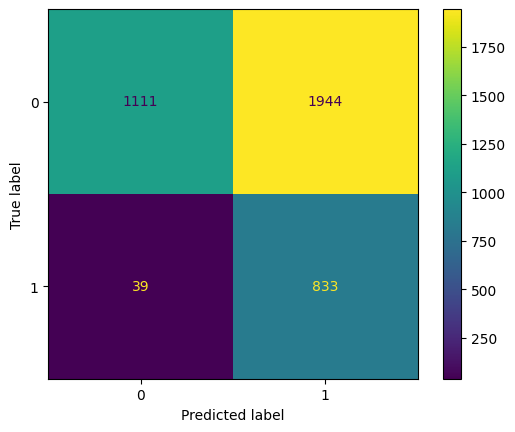

In [64]:
cm = metrics.confusion_matrix(y_test_np, y_pred, labels=best_tn_recall.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=best_tn_recall.classes_)
disp.plot()



Permutation Importance

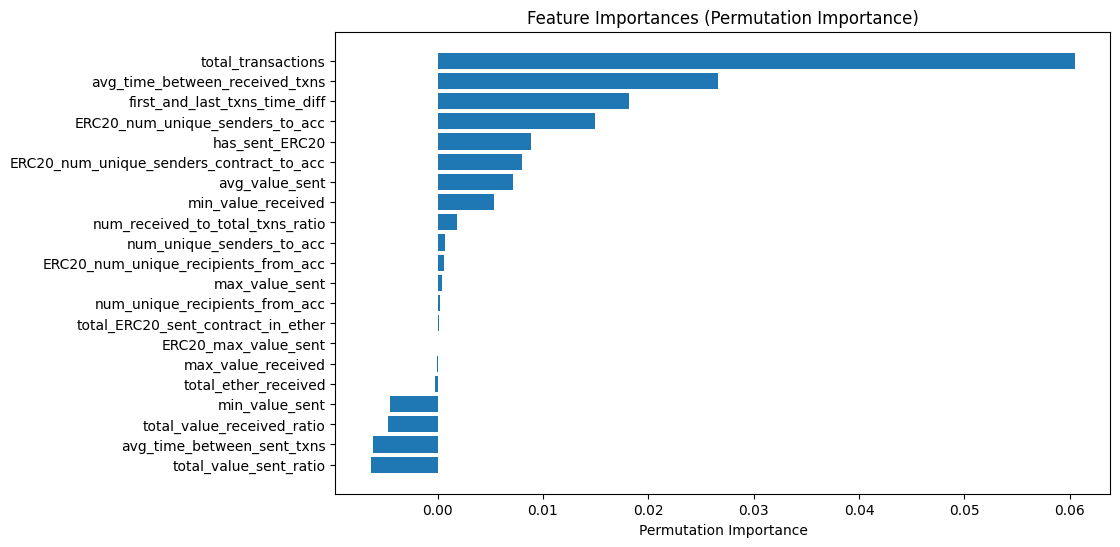

In [65]:
r = permutation_importance(best_model, X_test_np, y_test_np, scoring = 'recall',
                           n_repeats=30,
                           random_state=0)
# Get feature importances and their names
feature_importances = r.importances_mean
feature_names = X_test.columns

# Sort feature importances in descending order
sorted_idx = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_idx]
sorted_feature_names = np.array(feature_names)[sorted_idx]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_feature_importances)), sorted_feature_importances[::-1], align="center")
plt.yticks(range(len(sorted_feature_importances)), sorted_feature_names[::-1])
plt.xlabel("Permutation Importance")
plt.title("Feature Importances (Permutation Importance)")
plt.show()

In [68]:
import shap
import matplotlib

In [69]:
shap.initjs()

In [70]:
explainer = shap.KernelExplainer(best_model.predict_proba, shap.sample(X_train_np,20), feature_perturbation="interventional")

In [71]:
shap_values = explainer.shap_values(X_test_np)


  0%|          | 0/3927 [00:00<?, ?it/s]

100%|██████████| 3927/3927 [2:06:52<00:00,  1.94s/it]  


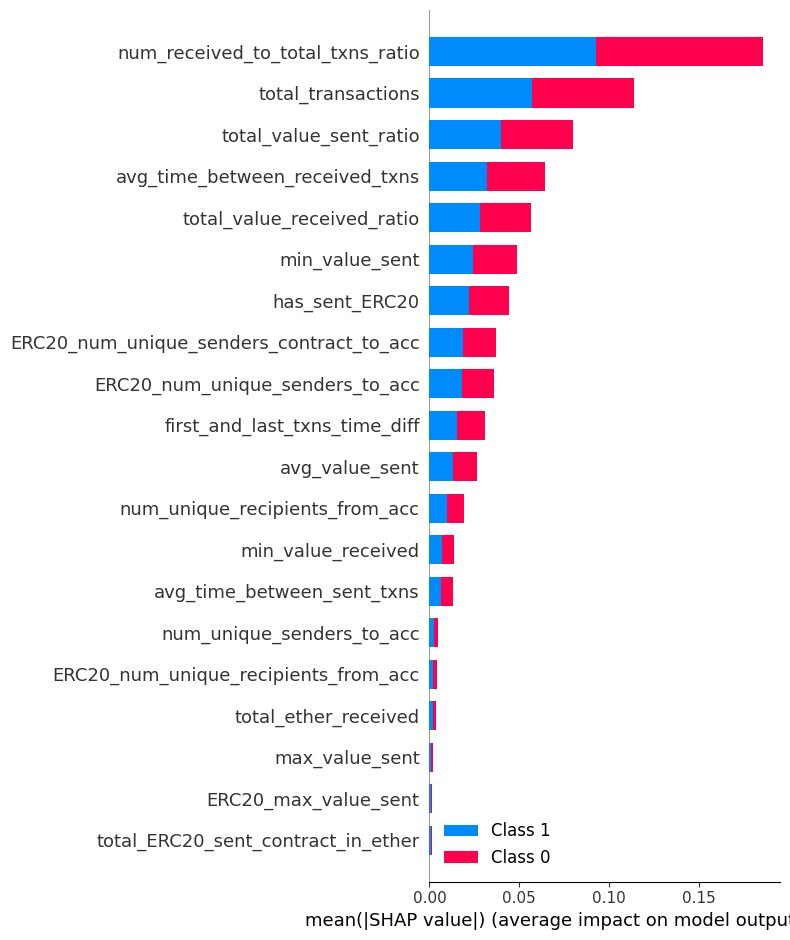

In [72]:
shap.summary_plot(shap_values, X_test_np, feature_names=X_test.columns, sort=True, plot_type="bar")
